# Data visualization

**Author**: Thiago Assumpção

**Summary**: In this notebook, we produce 1D and 2D plots of data from `NRPyElliptic` runs.

## Import necessary modules

In [1]:
import sys, os

In [2]:
os.chdir("/Users/thiago/Documents/PostDocProjects/headon-nrpyelliptic")
# os.chdir("../")
os.getcwd()

'/Users/thiago/Documents/PostDocProjects/headon-nrpyelliptic'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from post_processing.plot_functions import plot_2d

In [4]:
# Plotting settings
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "STIXGeneral"

In [5]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rc("text", usetex=True)
# plt.rc('font', family='serif')

## Import `NRPyElliptic` data

We begin by reading data from a relaxation performed with `NRPyElliptic`.

In [6]:
# Set path to data directory
# data_dir = os.path.join("project", "DATA_nrpyelliptic_headon_ns_zpos_5")
# data_dir = os.path.join("project", "DATA_nrpyelliptic_headon_ns_zpos_3")

data_dir = os.path.join("project", "DATA_nrpyelliptic_headon_ns_spherical")

In [7]:
def list_files_alphabetically(directory):
    return sorted([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))], key=str.lower)

In [8]:
# List files in alphabetical order for convenience
files_list = list_files_alphabetically(data_dir)

# Set up list with 1D output files
files_1D_r = [os.path.join(data_dir, file) for file in files_list if "out1d-r" in file]
files_1D_y = [os.path.join(data_dir, file) for file in files_list if "out1d-y" in file]
files_1D_z = [os.path.join(data_dir, file) for file in files_list if "out1d-z" in file]

# Set up list with 2D output files
files_2D_xy = [os.path.join(data_dir, file) for file in files_list if "out2d-xy" in file]
files_2D_yz = [os.path.join(data_dir, file) for file in files_list if "out2d-yz" in file]

# Plot 1D data

In [9]:
len(files_1D_r)

151

In [10]:
step_idx = -1

which_axis = "r"

if which_axis == "r":
    data_1d = files_1D_r[step_idx]
elif which_axis == "y":
    data_1d = files_1D_y[step_idx]
elif which_axis == "z":
    data_1d = files_1D_z[step_idx]
else:
    print(f"Plane {which_axis} not available to plot")
    sys.exit(1)

# Load data onto numpy arrays
zAxis, psi, alphaconf, residual_psi, residual_alphaconf, rho, P = np.loadtxt(data_1d).T

In [11]:
# Set TOV parameters
R_Schw_max = 9.566044579232511e-01
M = 1.405030336771405e-01 
rbar_max = 0.5 * (R_Schw_max - M + np.sqrt(R_Schw_max * (R_Schw_max - 2.0 * M)))

# Compute lapse function from numerical solution
alpha = (alphaconf + 1.0) / (psi + 1.0)

# Exact conformal factor
psi_exact = 1.0 + M / (2 * zAxis)

# Exact lapse function
alpha_exact = (1.0 - M / (2 * zAxis)) / (1.0 + M / (2 * zAxis))

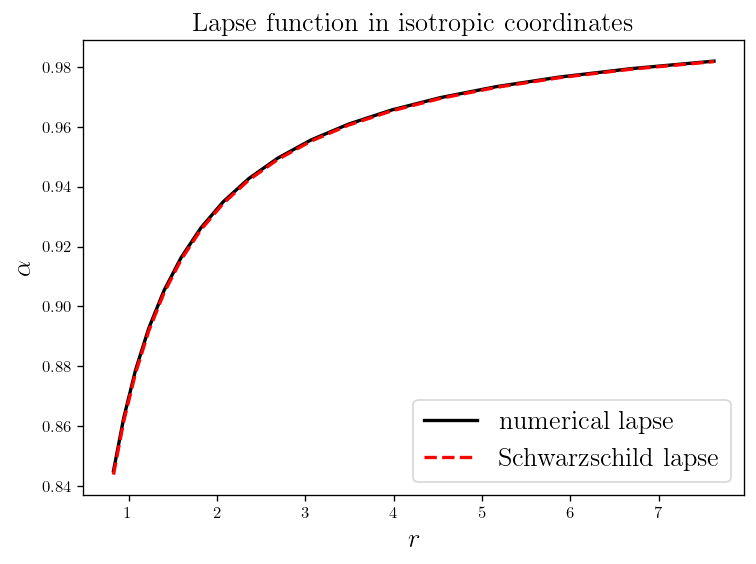

In [12]:
# Create a new figure
plt.figure(dpi=120)

# z_min = rbar_max
# z_max = 1.0e4
z_min = rbar_max
z_max = 7.5

idx_min = np.argmin(np.abs(zAxis - z_min))
idx_max = np.argmin(np.abs(zAxis - z_max)) + 1

axis_to_plot = zAxis[idx_min:idx_max]
func_to_plot1 = alpha[idx_min:idx_max]
func_to_plot2 = alpha_exact[idx_min:idx_max]

# Plot interpolated data along z-axis
# plt.scatter(axis_to_plot, func_to_plot1, color="red", label="conformal factor", s=1.0)
plt.plot(axis_to_plot, func_to_plot1, color="black", label="numerical lapse", lw=2.0)
plt.plot(axis_to_plot, func_to_plot2, color="red", ls="dashed", label="Schwarzschild lapse", lw=2.0)

plt.xlabel(r"$r$", fontsize=16)
plt.ylabel(r"$\alpha$", fontsize=16)

plt.title(r"Lapse function in isotropic coordinates", fontsize=16)  # Add a title here
plt.legend(fontsize=16);

# Show the plot
plt.tight_layout()
plt.show()


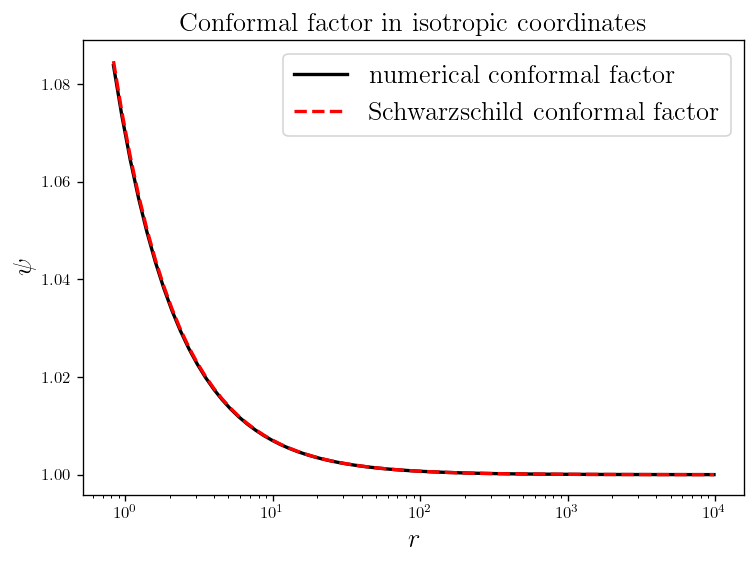

In [13]:
# Create a new figure
plt.figure(dpi=120)

z_min = rbar_max
z_max = 1.0e4

idx_min = np.argmin(np.abs(zAxis - z_min))
idx_max = np.argmin(np.abs(zAxis - z_max)) + 1

axis_to_plot = zAxis[idx_min:idx_max]
func_to_plot1 = 1.0 + psi[idx_min:idx_max]
func_to_plot2 = psi_exact[idx_min:idx_max]

# Plot interpolated data along z-axis
# plt.scatter(axis_to_plot, func_to_plot1, color="red", label="conformal factor", s=1.0)
plt.semilogx(axis_to_plot, func_to_plot1, color="black", label="numerical conformal factor", lw=2.0)
plt.plot(axis_to_plot, func_to_plot2, color="red", ls="dashed", label="Schwarzschild conformal factor", lw=2.0)

plt.xlabel(r"$r$", fontsize=16)
plt.ylabel(r"$\psi$", fontsize=16)

plt.title(r"Conformal factor in isotropic coordinates", fontsize=16)  # Add a title here
plt.legend(fontsize=16);

# Show the plot
plt.tight_layout()
plt.show()


In [14]:
# sys.exit(1)

# Interpolate 2D data

In [15]:
def interpolate_and_plot_along_z_axis(idx, horiz_min=-10, horiz_max=10, which_quantity="Phi", dpi=120):
      
    # We extract data on the yz plane
    which_plane = "yz"
    
    if which_plane == "xy":
        data_2d = files_2D_xy[idx]
        n_step = int(files_2D_xy[idx].split("-n-")[1].split(".txt")[0])
    elif which_plane == "yz":
        data_2d = files_2D_yz[idx]
        n_step = int(files_2D_yz[idx].split("-n-")[1].split(".txt")[0])
    else:
        print(f"Plane {which_plane} not available to plot")
        sys.exit(1)

    # Load data onto numpy arrays for
    yAxis, zAxis, psi, alphaconf, residual_psi, residual_alphaconf, rho, P = np.loadtxt(data_2d).T


    # Choose quantity to plot
    if which_quantity == "psi":
        plotquantity = psi
        plot_label_string = r"$\psi$"
    elif which_quantity == "alphaconf":
        plotquantity = alphaconf
        plot_label_string = r"$\tilde{\alpha}$"
    elif which_quantity == "residual_psi":
        plotquantity = residual_psi
        plot_label_string = r"residual_psi"
    elif which_quantity == "residual_alphaconf":
        plotquantity = residual_alphaconf
        plot_label_string = r"residual_alphaconf"
    elif which_quantity == "rho":
        plotquantity = rho
        plot_label_string = r"$\rho$"
    elif which_quantity == "P":
        plotquantity = P
        plot_label_string = r"$P$"
    else:
        print(f"which_quantitys = {which_quantitys} not recognized.")
        sys.exit(1)
    
    # Combine yAxis and zAxis into a 2D array
    points = np.array([yAxis, zAxis]).T

    # Choos axis fot 1D plot
    which_axis = "z"

    # Create a new figure
    plt.figure(dpi=dpi)

    # Set plotting range
    vert_min = -18
    vert_max = 10

    # Set the range of horizonral axis
    plt.xlim([horiz_min, horiz_max])
    
    # Set the range of vertical axis
    # plt.ylim([vert_min, vert_max])

    interpolation_method = "cubic"  # "linear" or "cubic"

    if which_axis=="y":
    
        # Define the points where you want to interpolate
        grid_y = np.linspace(horiz_min, horiz_max, num=10000)
        grid_z = np.zeros_like(grid_y)
        
        # Interpolate along y-axis (z=0)
        xi_y = np.array([grid_y, grid_z]).T
        ui_y = griddata(points, plotquantity, xi_y, method=interpolation_method, rescale=True)
        
        # Plot interpolated data along y-axis
        plt.plot(grid_y, ui_y,   color="black", ls = "solid", label = fr"step $n ={n_step}$", lw=1)
    
        plt.xlabel(r"$y$", fontsize=16)
        plt.title(rf"{which_quantity} along $y$-axis", fontsize=16)  # Add a title here

    elif which_axis=="z":
    
        # Define the points where you want to interpolate
        grid_z = np.linspace(horiz_min, horiz_max, num=10000)
        grid_y = np.zeros_like(grid_z)
        
        # Interpolate along z-axis (y=0)
        xi_z = np.array([grid_y, grid_z]).T
        ui_z = griddata(points, plotquantity, xi_z, method=interpolation_method, rescale=True)
        
        # Plot interpolated data along z-axis
        plt.plot(grid_z, ui_z, color="black", ls = "solid", label = fr"$n ={n_step}$", lw=1)
        # plt.scatter(grid_z, ui_z, color="black", label = fr"$n ={n_step}$", s=0.1)
    
        plt.xlabel(r"$z$", fontsize=16)
        plt.title(rf"{which_quantity} along $z$-axis", fontsize=16)  # Add a title here
    
    
    # Show the plot
    plt.ylabel(plot_label_string, fontsize=16)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

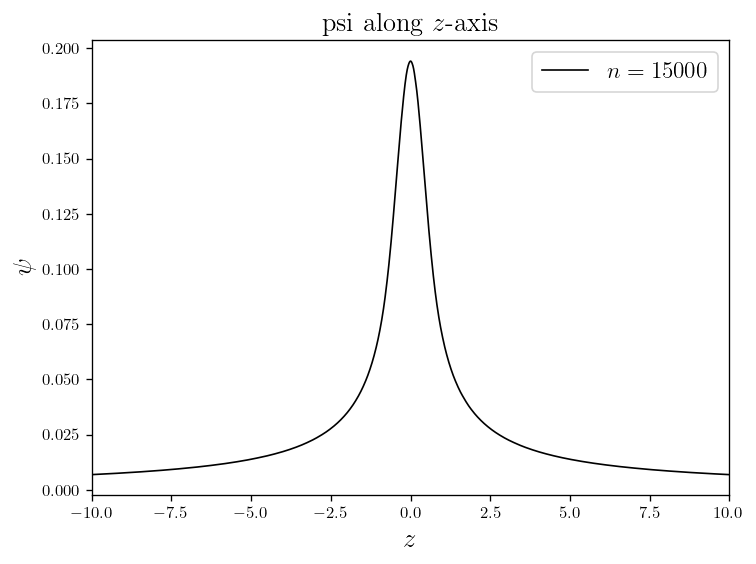

In [16]:
interpolate_and_plot_along_z_axis(
    idx=-1, 
    horiz_min=-10, 
    horiz_max=10,
    which_quantity="psi",
    dpi=120,
)

In [17]:
from post_processing.plot_functions import plot_2d

In [18]:
# Data index
data_idx = -1

# We extract data from the last outputted step
which_plane = "yz"

if which_plane == "xy":
    data_2d = files_2D_xy[data_idx]
elif which_plane == "yz":
    data_2d = files_2D_yz[data_idx]
else:
    print(f"Plane {which_plane} not available to plot")
    sys.exit(1)

# Load data onto numpy arrays
yAxis, zAxis, psi, alphaconf, residual_psi, residual_alphaconf, rho, P = np.loadtxt(data_2d).T

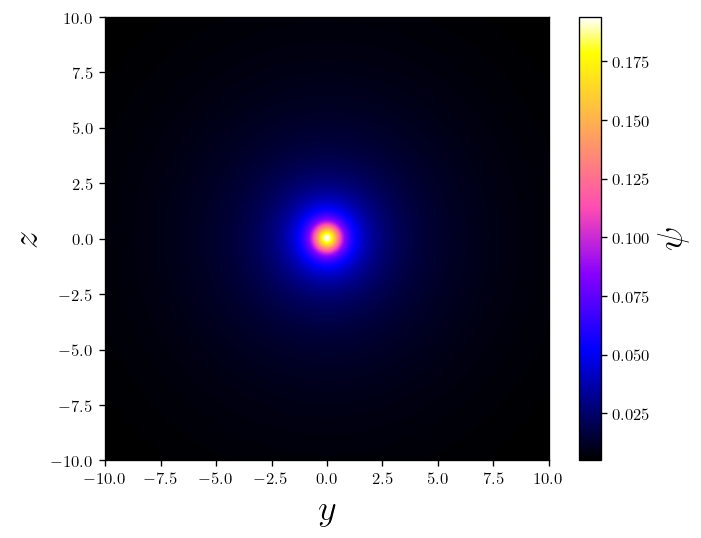

In [19]:
plot_2d(
    plotquantity=psi,
    func_str_label=r"$\psi$",
    # plotquantity=np.ones_like(Phi)*(-17),
    x_data=yAxis,
    y_data=zAxis,
    xy_center = [0, 0],
    xy_plot_range= [10, 10],
    axes_label = "yz",
    # ylim = [-16, -1],
    # func_str_title = r"Kinetic term $\sqrt{X} = (\partial^i\Phi\partial_i\Phi)^{1/2}$",
    # func_str_label=r"$\sqrt{X} = (\partial^i\Phi\partial_i\Phi)^{1/2}$",
    plot_gpts=False,
    dpi=120,
    label_fontsize=22,
    # title_fontsize=20,
    num_contours=30,
    # cmap="viridis",
    cmap="gnuplot2",
    plot_contours=False,
    log_scale=False,
    save_path=None,
)